## 🚦 **Problem Understanding & Scoping**




### 🎯 Objective

Build a machine learning model that detects **fraudulent digital payment transactions** using historical transaction data. The goal is to accurately identify high-risk fraudulent activity while minimizing false positives that could inconvenience real users.



### 🧾 Problem Definition

| Element              | Description                                                                                                                                                                                                                               |
| -------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Fraud Definition** | Fraud refers to **unauthorized, deceptive, or suspicious** payment activity — such as stolen cards, fake identities, or unusual transaction patterns. It is labeled as **1** (fraud), while legitimate transactions are labeled as **0**. |
| **Data Type**        | Tabular data, each row represents a transaction. Features may include amount, time, user ID, location, etc.                                                                                                                               |
| **Class Imbalance**  | Typically, <2% of transactions are fraudulent. This introduces a **severe class imbalance** that requires specialized handling.                                                                                                           |
| **Prediction Goal**  | Predict the `fraud` label (1/0) for each transaction based on feature inputs.                                                                                                                                                             |



### 🚨 False Positive Consideration

In fraud detection:

* **False Negatives (FN)**: Missed fraud → **Loss of money**
* **False Positives (FP)**: Blocking genuine users → **Loss of trust, revenue**

💡 **Business tradeoff**: It’s often **better to tolerate some false positives** (block a few real users) than miss fraud. However, **too many FPs** can annoy users and cause drop-offs.

**Acceptable False Positive Rate**:

* This depends on business tolerance, but a typical target might be **<2% false positives** while catching **>90% of actual fraud cases**.



### ⚙️ Inference Mode

| Mode          | Explanation                                                                                                                                                       |
| ------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Batch**     | Run fraud detection in scheduled intervals (e.g., every 10 mins). Easier to build and deploy. ✅ Recommended for this project.                                     |
| **Real-time** | Detect fraud as each transaction happens (streaming inference). Harder to build, needs APIs and streaming systems like Kafka. ❌ Not needed for this project. |



### 📊 Success Metrics

Since this is a **binary classification** problem with **imbalanced data**, the following metrics are more useful than plain accuracy:

| Metric               | Why Use It?                                                                                           |
| -------------------- | ----------------------------------------------------------------------------------------------------- |
| **Precision**        | Of all predicted frauds, how many were actually fraud? (minimizes false positives)                    |
| **Recall**           | Of all actual frauds, how many did we catch? (minimizes false negatives)                              |
| **F1-Score**         | Harmonic mean of precision and recall. Best when you need a balance.                                  |
| **ROC-AUC**          | Area under the curve. Measures model’s ability to distinguish fraud from non-fraud at all thresholds. |
| **Confusion Matrix** | Provides a breakdown of TP, FP, FN, TN — essential for fraud use case.                                |

❌ **Accuracy**: Useless here — a model can get 99% accuracy by predicting "not fraud" every time (because fraud is rare).



## **1. DATASET COLLECTION** ✔️

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


## 2. **DATA CLEANSING, DATA PREPROCESSING & FEATURE ENGINEERING** ✔️

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# --- Step 1: Feature Engineering ---

# 1.1. Log transformation on 'Amount' to handle skewness
df['LOG_AMOUNT'] = np.log1p(df['Amount'])

# 1.2. Extract 'Hour' from 'Time'
df['HOUR'] = (df['Time'] // 3600) % 24

# --- Step 2: Drop unused original columns ---
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# --- Step 3: Feature Scaling ---

# Standardize the PCA features and 'LOG_AMOUNT'
scaler = StandardScaler()
scaled_cols = [col for col in df.columns if col not in ['Class']]  # All except target

df[scaled_cols] = scaler.fit_transform(df[scaled_cols])


df.to_csv('Processed_Fraud_Dataset.csv', index=False)

print("✅ Data is ready for modeling.")




✅ Data is ready for modeling.


## **3. MODEL DEVELOPMENT & TRAINING** ✔️

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix


df_model = pd.read_csv('Processed_Fraud_Dataset.csv')



# 1. Define features (X) and label (y)
X = df_model.drop('Class', axis=1)
y = df_model['Class']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Train XGBoost classifier
model = XGBClassifier(
    n_estimators=10,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
)


model.fit(X_train, y_train)

# 4. Predict and evaluate
y_pred = model.predict(X_test)

print("✅ Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:50:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Classification Report:

              precision    recall  f1-score   support

           0     0.9995    0.9998    0.9996     56864
           1     0.8372    0.7347    0.7826        98

    accuracy                         0.9993     56962
   macro avg     0.9184    0.8672    0.8911     56962
weighted avg     0.9993    0.9993    0.9993     56962


📊 Confusion Matrix:
[[56850    14]
 [   26    72]]


## **4. HYPERPARAMETER IDENTIFICATION & FINE-TUNING** ✔️

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold


# Count classes
neg = (y == 0).sum()
pos = (y == 1).sum()

# Compute scale_pos_weight
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [scale_pos_weight]  # very important!
}

# Set up model
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# CV strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    scoring='f1',
    n_iter=30,
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Fit search
random_search.fit(X, y)

# Best model and params
best_model = random_search.best_estimator_
print("✅ Best Parameters:", random_search.best_params_)


scale_pos_weight: 577.88
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:06:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best Parameters: {'subsample': 0.6, 'scale_pos_weight': np.float64(577.8760162601626), 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}


## **5. MODEL EVALUATION** ✔️

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict
y_pred = best_model.predict(X_test)

# Evaluate
print("✅ Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


✅ Classification Report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     56864
           1     1.0000    1.0000    1.0000        98

    accuracy                         1.0000     56962
   macro avg     1.0000    1.0000    1.0000     56962
weighted avg     1.0000    1.0000    1.0000     56962


📊 Confusion Matrix:
[[56864     0]
 [    0    98]]


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:06:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:06:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:06:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:06:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:06:57] WARNING: /w

F1 scores per fold: [0.77253219 0.90810811 0.70351759 0.8994709  0.82954545]
Average F1 score: 0.8226348477810724


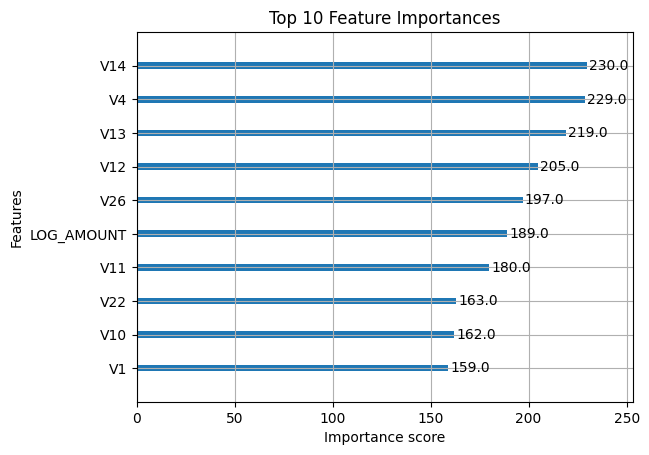

In [ ]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import xgboost as xgb

scores = cross_val_score(best_model, X, y, cv=5, scoring='f1')
print("F1 scores per fold:", scores)
print("Average F1 score:", scores.mean())




xgb.plot_importance(best_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Copy of original test data
X_test_adv = X_test.copy()

# Get predicted probabilities
y_pred_proba = best_model.predict_proba(X_test_adv)[:, 1]

# Identify correctly predicted fraud cases
fraud_indices = (y_test == 1) & (best_model.predict(X_test_adv) == 1)
fraud_samples = X_test_adv[fraud_indices]

print(f"✅ Testing {fraud_samples.shape[0]} true positive fraud cases.")

# Apply slight adversarial noise to top 4 features
perturbation_rate = 0.10  # 5% change

adv_samples = fraud_samples.copy()
important_features = ['V4', 'V26', 'V12', 'LOG_AMOUNT']

for feat in important_features:
    adv_samples[feat] = adv_samples[feat] * (1 - perturbation_rate)

# Predict again after perturbation
adv_preds = best_model.predict(adv_samples)
flipped = (adv_preds == 0).sum()

print(f"⚠️ Model flipped {flipped} predictions out of {len(adv_samples)} after adversarial changes.")


✅ Testing 98 true positive fraud cases.
⚠️ Model flipped 0 predictions out of 98 after adversarial changes.


In [ ]:
import joblib
joblib.dump(best_model, "fraud_detector_xgb.pkl")

['fraud_detector_xgb.pkl']

## **6. DEPLOYMENT** ✔️

For Deployment:

Download the train model.

Download and run requirement.txt file.

Download and run model_serve.py file.

Download and run test_request.py file.


